In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## Котировки

In [2]:
df = pd.read_csv('Data/TQBR.SBER_D1.txt', sep='\t')

In [3]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

C:\Users\yaroslav\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


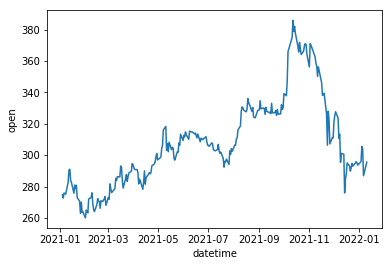

In [4]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

In [5]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')
df.head()

,open,high,low,close,volume
datetime,,,,,
2021-01-04,274.67,276.60,270.61,272.00,4879946
2021-01-05,272.67,275.70,270.28,275.20,4555410
2021-01-06,275.90,275.92,271.62,272.93,4090534
2021-01-08,275.11,283.99,275.11,283.64,8867294
2021-01-11,282.75,292.95,279.48,289.49,11221040


## Индикаторы

In [6]:
def get_roc(close, n):
    difference = close.diff(n)
    nprev_values = close.shift(n)
    roc = (difference / nprev_values) * 100
    return roc

In [8]:
# KST CALCULATION

def get_kst(close, sma1, sma2, sma3, sma4, roc1, roc2, roc3, roc4, signal):
    rcma1 = get_roc(close, roc1).rolling(sma1).mean()
    rcma2 = get_roc(close, roc2).rolling(sma2).mean()
    rcma3 = get_roc(close, roc3).rolling(sma3).mean()
    rcma4 = get_roc(close, roc4).rolling(sma4).mean()
    kst = (rcma1 * 1) + (rcma2 * 2) + (rcma3 * 3) + (rcma4 * 4)
    signal = kst.rolling(signal).mean()
    return kst, signal

df['kst'], df['signal_line'] = get_kst(df['close'], 10, 10, 10, 15, 10, 15, 20, 30, 9)
df.tail()

,open,high,low,close,volume,kst,signal_line
datetime,,,,,,,
2022-01-03,295.90,305.50,294.34,305.47,5015626,-100.647104,-122.757163
2022-01-04,305.51,310.10,301.63,304.24,5326822,-89.089940,-117.286396
2022-01-05,303.56,304.26,287.00,287.01,7001594,-83.083102,-111.428299
2022-01-06,286.86,295.10,281.00,293.92,7932941,-74.589082,-104.751831
2022-01-10,295.52,298.88,289.60,291.41,4619797,-68.014182,-97.640811


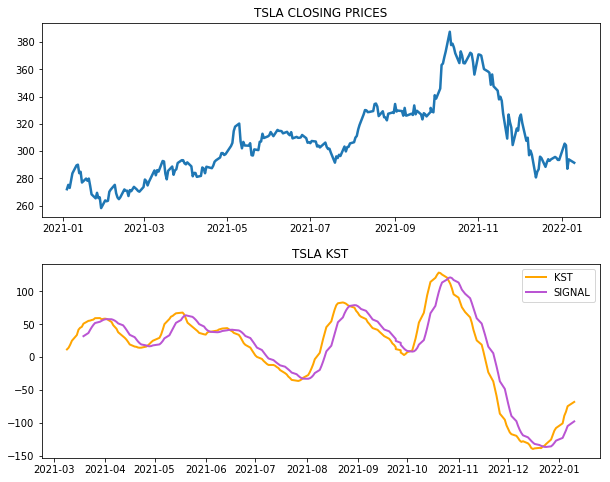

In [11]:
# KST INDICATOR PLOT

plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 2.5)
ax1.set_title('TSLA CLOSING PRICES')
ax2.plot(df['kst'], linewidth = 2, label = 'KST', color = 'orange')
ax2.plot(df['signal_line'], linewidth = 2, label = 'SIGNAL', color = 'mediumorchid')
ax2.legend()
ax2.set_title('TSLA KST')
plt.show()

## TRADING STRATEGY

In [12]:
# KST CROSSOVER TRADING STRATEGY

def implement_kst_strategy(prices, kst_line, signal_line):
    buy_price = []
    sell_price = []
    kst_signal = []
    signal = 0
    
    for i in range(len(kst_line)):
        
        if kst_line[i-1] < signal_line[i-1] and kst_line[i] > signal_line[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kst_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kst_signal.append(0)
                
        elif kst_line[i-1] > signal_line[i-1] and kst_line[i] < signal_line[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kst_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kst_signal.append(0)
                
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kst_signal.append(0)
            
    return buy_price, sell_price, kst_signal

buy_price, sell_price, kst_signal = implement_kst_strategy(df['close'], df['kst'], df['signal_line'])

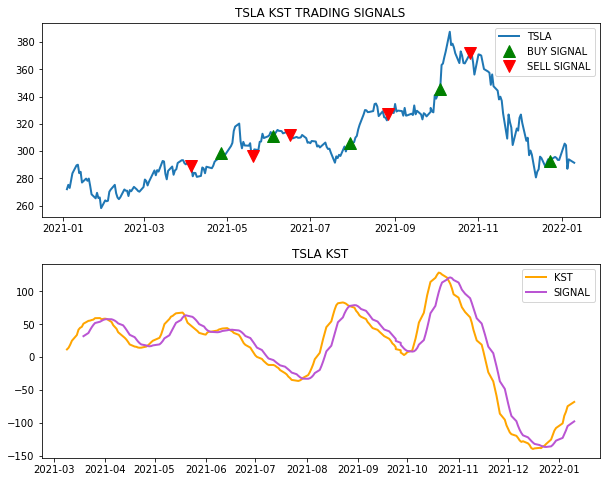

In [13]:
# TRADING SIGNALS PLOT
plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 2, label = 'TSLA')
ax1.plot(df.index, buy_price, marker = '^', markersize = 12, linewidth = 0, color = 'green', label = 'BUY SIGNAL')
ax1.plot(df.index, sell_price, marker = 'v', markersize = 12, linewidth = 0, color = 'r', label = 'SELL SIGNAL')
ax1.legend()
ax1.set_title('TSLA KST TRADING SIGNALS')
ax2.plot(df['kst'], linewidth = 2, label = 'KST', color = 'orange')
ax2.plot(df['signal_line'], linewidth = 2, label = 'SIGNAL', color = 'mediumorchid')
ax2.legend()
ax2.set_title('TSLA KST')
plt.show()

In [25]:
strategy.loc[lambda x: abs(x.kst_signal)==1]

,close,kst,signal_line,kst_signal,kst_position
datetime,,,,,
2021-04-05,288.78,53.648139,57.707295,-1,0
2021-04-27,298.50,17.996700,16.944566,1,1
2021-05-20,296.72,58.715249,63.740150,-1,0
2021-06-04,310.94,38.736047,38.600289,1,1
2021-06-16,311.61,40.742296,41.729807,-1,0
2021-07-30,305.59,-31.219259,-32.673903,1,1
2021-08-27,327.41,77.727715,77.895035,-1,0
2021-10-04,345.85,10.306153,8.552573,1,1
2021-10-26,372.16,116.494334,120.600927,-1,0


## POSITION

In [16]:
# STOCK POSITION

position = []
for i in range(len(kst_signal)):
    if kst_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df['close'])):
    if kst_signal[i] == 1:
        position[i] = 1
    elif kst_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = df['close']
kst = df['kst']
signal_line = df['signal_line']
kst_signal = pd.DataFrame(kst_signal).rename(columns = {0:'kst_signal'}).set_index(df.index)
position = pd.DataFrame(position).rename(columns = {0:'kst_position'}).set_index(df.index)

frames = [close_price, kst, signal_line, kst_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,close,kst,signal_line,kst_signal,kst_position
datetime,,,,,
2021-01-04,272.00,NaN,NaN,0,1
2021-01-05,275.20,NaN,NaN,0,1
2021-01-06,272.93,NaN,NaN,0,1
2021-01-08,283.64,NaN,NaN,0,1
2021-01-11,289.49,NaN,NaN,0,1
...,...,...,...,...,...
2022-01-03,305.47,-100.647104,-122.757163,0,1
2022-01-04,304.24,-89.089940,-117.286396,0,1
2022-01-05,287.01,-83.083102,-111.428299,0,1


## BACKTEST

In [24]:
# BACKTESTING

tsla_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
kst_strategy_ret = []

for i in range(len(tsla_ret)):
    returns = tsla_ret['returns'][i]*strategy['kst_position'][i]
    kst_strategy_ret.append(returns)
    
kst_strategy_ret_df = pd.DataFrame(kst_strategy_ret).rename(columns = {0:'kst_returns'})
investment_value = 100000
number_of_stocks = investment_value/df['close'][0]
kst_investment_ret = []

for i in range(len(kst_strategy_ret_df['kst_returns'])):
    returns = number_of_stocks*kst_strategy_ret_df['kst_returns'][i]
    kst_investment_ret.append(returns)
    kst_investment_ret_df = pd.DataFrame(kst_investment_ret).rename(columns = {0:'investment_returns'})

total_investment_ret = round(sum(kst_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the KST strategy by investing $100k in TSLA : {}'.format(total_investment_ret))
print('Profit percentage of the KST strategy : {}%'.format(profit_percentage))

Profit gained from the KST strategy by investing $100k in TSLA : 22944.85
Profit percentage of the KST strategy : 22.94485%


In [26]:
# сбер
strategy.kst_signal.value_counts()

 0    252
-1      5
 1      5
Name: kst_signal, dtype: int64